In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

In [2]:
from sedona.spark import *

config = SedonaContext.builder() \
    .master("local[*]") \
    .appName("SedonaSample") \
    .config('spark.jars.packages', 
            'org.apache.sedona:sedona-spark-3.5_2.12:1.6.0,'
            'org.datasyslab:geotools-wrapper:1.6.0-28.2'
        ) \
    .getOrCreate()
sedona = SedonaContext.create(config)

24/07/02 16:30:16 WARN Utils: Your hostname, Makotos-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.138.141.116 instead (on interface en0)
24/07/02 16:30:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/Mak/.pyenv/versions/3.11.2/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/Mak/.ivy2/cache
The jars for the packages stored in: /Users/Mak/.ivy2/jars
org.apache.sedona#sedona-spark-3.5_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ceb8fb33-f1a6-4651-a7f2-16c33d8f4b02;1.0
	confs: [default]
	found org.apache.sedona#sedona-spark-3.5_2.12;1.6.0 in central
	found org.apache.sedona#sedona-common;1.6.0 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found org.locationtech.jts#jts-core;1.19.0 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found org.locationtech.spatial4j#spatial4j;0.8 in central
	found com.google.geometry#s2-geometry;2.0.0 in central
	found com.google.guava#guava;25.1-jre in central
	found com.google.code.findbugs#jsr305;3.0.2 in central
	found org.checkerframework#checker-qual;2.0.0 in central
	found com.google.errorprone#error_prone_annotations;2.1.3 in central
	found com.google.j2ob

24/07/02 16:30:31 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [6]:
data_path = "NGSIM_Data.csv"

df = sedona.read.csv(data_path, header=True)
df.count()

11850526

In [25]:
df.show()

+----------+--------+------------+-------------+-------+--------+-----------+-----------+--------+-------+-------+-----+-----+-------+------+------+------+----------+---------+--------+---------+---------+-------------+------------+----------+
|Vehicle_ID|Frame_ID|Total_Frames|  Global_Time|Local_X| Local_Y|   Global_X|   Global_Y|v_length|v_Width|v_Class|v_Vel|v_Acc|Lane_ID|O_Zone|D_Zone|Int_ID|Section_ID|Direction|Movement|Preceding|Following|Space_Headway|Time_Headway|  Location|
+----------+--------+------------+-------------+-------+--------+-----------+-----------+--------+-------+-------+-----+-----+-------+------+------+------+----------+---------+--------+---------+---------+-------------+------------+----------+
|       515|    2330|        1123|1118848075000| 30.034| 188.062|6451203.729|1873252.549|      13|    6.9|      2|23.31| 2.05|      3|    NA|    NA|    NA|        NA|       NA|      NA|      500|      523|        119.1|        5.11|    us-101|
|       515|    2330|   

In [79]:
df = df.withColumn("datetime", F.timestamp_millis(F.col("Global_Time").cast("long")))
df.show()

+----------+--------+------------+-------------+-------+--------+-----------+-----------+--------+-------+-------+-----+-----+-------+------+------+------+----------+---------+--------+---------+---------+-------------+------------+----------+--------------------+
|Vehicle_ID|Frame_ID|Total_Frames|  Global_Time|Local_X| Local_Y|   Global_X|   Global_Y|v_length|v_Width|v_Class|v_Vel|v_Acc|Lane_ID|O_Zone|D_Zone|Int_ID|Section_ID|Direction|Movement|Preceding|Following|Space_Headway|Time_Headway|  Location|            datetime|
+----------+--------+------------+-------------+-------+--------+-----------+-----------+--------+-------+-------+-----+-----+-------+------+------+------+----------+---------+--------+---------+---------+-------------+------------+----------+--------------------+
|       515|    2330|        1123|1118848075000| 30.034| 188.062|6451203.729|1873252.549|      13|    6.9|      2|23.31| 2.05|      3|    NA|    NA|    NA|        NA|       NA|      NA|      500|      523|

In [80]:
df = df.withColumns({
    "day": F.dayofmonth(F.col("datetime")),
    "month": F.month(F.col("datetime")),
    "hour": F.hour(F.col("datetime")),
    })

In [81]:
counts = df.groupBy(["day", "month", "hour", "Location"]).count()
counts.show()

+---+-----+----+----------+-------+
|day|month|hour|  Location|  count|
+---+-----+----+----------+-------+
| 15|    6|  16|    us-101|4065618|
| 16|    6|  16|lankershim|1566176|
| 14|    4|   1|      i-80|3293018|
| 15|    6|  15|    us-101| 737315|
| 13|    4|  23|      i-80|  24208|
| 14|    1|  12| peachtree| 873887|
| 16|    6|  17|lankershim|  41143|
| 14|    4|   0|      i-80|1249161|
+---+-----+----+----------+-------+



In [82]:
i80 = df.filter((F.col("Location") == "i-80") & (F.col("hour") == 23))

In [83]:
i80_cord = i80.select("Global_X", "Global_Y")
i80_cord.show()

+-----------+-----------+
|   Global_X|   Global_Y|
+-----------+-----------+
|6042887.556|2133157.281|
|6042854.266|2133440.532|
|6042768.748|2133722.881|
|6042880.179|2133207.014|
|6042762.406|2133783.776|
|6042792.849|2133421.999|
|6042876.691|2133232.231|
|6042787.699|2133463.741|
|6042835.194|2133177.718|
|6042818.306|2133321.706|
| 6042803.73| 2133346.44|
|6042803.084|2133351.444|
|6042824.031|2133272.726|
|6042772.029|2133607.619|
|6042834.554|2133182.827|
|6042824.243|2133270.912|
|6042763.628|2133773.409|
|6042770.807|2133666.971|
|6042887.636|2133156.406|
|6042752.242|2133934.643|
+-----------+-----------+
only showing top 20 rows



In [84]:
i80.createOrReplaceTempView("i80")
df_with_geom = spark.sql("Select *, ST_Point(Global_X, Global_Y) AS geometry from i80")
df_with_geom.createOrReplaceTempView("df_with_geom")
df_with_geom.head()

Row(Vehicle_ID='3333', Frame_ID='477', Total_Frames='739', Global_Time='1113433182600', Local_X='66.896', Local_Y='82.255', Global_X='6042887.556', Global_Y='2133157.281', v_length='15.3', v_Width='6.9', v_Class='2', v_Vel='2.8', v_Acc='6.62', Lane_ID='6', O_Zone=None, D_Zone=None, Int_ID=None, Section_ID=None, Direction=None, Movement=None, Preceding='103', Following='0', Space_Headway='17', Time_Headway='6.07', Location='i-80', datetime=datetime.datetime(2005, 4, 13, 23, 59, 42, 600000), day=13, month=4, hour=23, geometry=<POINT (6042887.556 2133157.281)>)

In [85]:
pdf = df_with_geom.toPandas()

<Axes: >

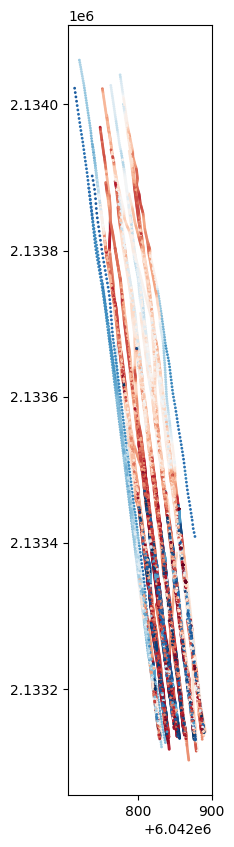

In [86]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(pdf, geometry="geometry")

gdf.plot(
    figsize=(10, 10),
    column="v_Vel",
    cmap="RdBu",
    markersize=1,
)

In [88]:
from geotorchai.preprocessing import load_geo_data
from geotorchai.preprocessing.enums import GeoFileType
spatial_i80_rdd = load_geo_data("i-80.shp",  GeoFileType.SHAPE_FILE)

SparkSessionInitException: sparkContext was not initialized correctly

24/06/26 21:57:36 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1048380 ms exceeds timeout 120000 ms
24/06/26 21:57:36 WARN SparkContext: Killing executors is not supported by current scheduler.
24/06/26 21:57:39 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$